In [1]:
import simi

import pandas as pd
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

EMBEDDING = models.Transformer('math-similarity/Bert-MLM_arXiv') # use model hosted on huggingface
# EMBEDDING = models.Transformer('./bert+re-train_mlm_abstracts_arxiv') # use locally generated model
POOLING = models.Pooling(EMBEDDING.get_word_embedding_dimension())
# POOLING = models.Pooling(EMBEDDING.get_word_embedding_dimension(), pooling_mode="cls") # CLS pooling

MODEL = SentenceTransformer(modules=[EMBEDDING, POOLING])

RANDOM_STATE = 1

def similarity_scoring(df, model, append=False):
    scores = df.apply(lambda r: simi.pairwise_cosine_similarity(simi.model_embeddings(model, [r["text_a"], r["text_b"]]))[0][0], axis=1)
    scores = pd.Series(scores, index=df.index, name="cosine-sim")
    if append:
        return df.merge(scores.to_frame(), left_index=True, right_index=True)
    return scores

2023-05-10 16:32:05.329025: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Some weights of the model checkpoint at ./bert+re-train_mlm_abstracts_arxiv were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you

In [2]:
df = pd.read_csv("class-arxiv-dataset.csv", index_col=0)
df["label"] = df["label"].astype("float")
# TODO: the mathberta tokenizer also recognizes latex within [MATH]...[/MATH] -> convert latex markupp in titles accordingly
df.sample(5)

,label,categories_a,text_a,categories_b,text_b
49557,1.0,"('math.RT',)",Generic bases for cluster algebras and the Cha...,"('math.RT',)",Super-representations of quivers and related p...
27681,1.0,"('math.GM',)",Probabilistic approach to the distribution of ...,"('math.GM',)",Random Distances Associated with Hexagons. In ...
39931,0.0,"('math.OA',)",The Dixmier-Douady Class of Groupoid Crossed P...,"('math.NT',)",Topological properties of $q$-analogues of mul...
5282,1.0,"('math.AP',)","Convergence problem of Schr\""odinger equation ...","('math.AP',)",On the speed rate of convergence of solutions ...
39609,1.0,"('math.OA',)",Stable isomorphism of dual operator spaces. We...,"('math.OA',)",The Operator System Generated by Cuntz Isometr...


In [3]:
X_treval, X_test = train_test_split(df, train_size=0.9, random_state=RANDOM_STATE)
X_train, X_eval = train_test_split(X_treval, train_size=0.888889, random_state=RANDOM_STATE)
print("train:", len(X_train), "eval:", len(X_eval), "test:", len(X_test))

train: 43572 eval: 5447 test: 5447


In [4]:
# prepare evaluation data
eval_examples = X_eval.reset_index(drop=True).apply(lambda r: InputExample(texts=[r["text_a"], r["text_b"]], label=r["label"]), axis=1)
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(eval_examples)

In [5]:
# prepare re-training: training data, loss
retrain_examples = X_train.reset_index(drop=True).apply(lambda r: InputExample(texts=[r["text_a"], r["text_b"]], label=r["label"]), axis=1)
retrain_dataloader = DataLoader(retrain_examples, shuffle=True, batch_size=10)
#retrain_loss = losses.SoftmaxLoss(model=MODEL, num_labels=2,
#        sentence_embedding_dimension=MODEL.get_sentence_embedding_dimension())
#retrain_loss = losses.ContrastiveLoss(model=MODEL)
retrain_loss = losses.CosineSimilarityLoss(model=MODEL)

In [6]:
%%time
# finetune model
MODEL.fit(train_objectives=[(retrain_dataloader, retrain_loss)], evaluator=evaluator, epochs=10,
        output_path="bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv") 

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4358 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4358 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4358 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4358 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4358 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4358 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4358 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4358 [00:00<?, ?it/s]

Iteration:   0%|          | 0/4358 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



CPU times: user 14h 26min 42s, sys: 2h 8min 42s, total: 16h 35min 24s
Wall time: 14h 59min 40s


In [7]:
%%time
# evaluate Spearman-Pearson-rank-coefficient on test data
spear_ranc = MODEL.evaluate(evaluator)
spear_ranc

CPU times: user 3min 33s, sys: 7.32 s, total: 3min 40s
Wall time: 2min 12s


0.7971517440229714

In [8]:
%%time
# evaluate model with test data
X_test_score = similarity_scoring(X_test, MODEL, append=True)

CPU times: user 3min 15s, sys: 2.98 s, total: 3min 18s
Wall time: 2min 48s


In [9]:
pd.set_option('display.max_colwidth', 160)

In [10]:
X_test_score.sample(15, random_state=RANDOM_STATE)

,label,categories_a,text_a,categories_b,text_b,cosine-sim
14175,1.0,"('math.CO',)","On Weak Chromatic Polynomials of Mixed Graphs. A \emph{mixed graph} is a graph with directed edges, called arcs, and undirected edges. A $k$-coloring of the...","('math.CO',)","Projective Equivalences of k-neighbourly Polytopes. We prove the following theorem, which is related to McMullen's problem on projective transformations of ...",0.998671
29240,1.0,"('math.GR',)","Galois Theory - a first course. These notes are a self-contained introduction to Galois theory, designed for the student who has done a first course in abst...","('math.GR',)",On p-stability in groups and fusion systems. The aim of this paper is to generalise the notion of p-stability to fusion systems. We study the question how Q...,0.482188
31864,1.0,"('math.KT',)",Controlled $K$-theory and $K$-Homology. An operator $T$ in a $C^*$-algebra is called an $\epsilon$-projection if it satisfies $T=T^*$ and $\|T^2-T\|<\epsilo...,"('math.KT',)","Cyclic homology of braided Hopf crossed products. Let k be a field, A a unitary associative k-algebra and V a k-vector space endowed with a distinguished el...",0.855590
48373,1.0,"('math.RA',)",Simple subalgebras of simple special Jordan algebras. In this paper we determine all types and the canonical forms of simple subalgebras for each type of si...,"('math.RA',)",Normalization of Quaternionic Polynomials. Quaternionic polynomials are generated by quaternionic variables and the quaternionic product. This paper propose...,0.681340
11994,1.0,"('math.CA',)","On some Hadamard-Type Inequalities for Co-ordinated Convex Functions. In this paper, we prove some new inequalities of Hadamard-type for convex functions on...","('math.CA',)",Non-differentiable solutions for local fractional nonlinear Riccati differential equations. We investigate local fractional nonlinear Riccati differential e...,0.698279
48427,1.0,"('math.RA',)",Basic superranks for varieties of algebras. We introduce the notion of basic superrank for varieties of algebras which generalizes that of basic rank. First...,"('math.RA',)","A note on solvable maximal subgroups in subnormal subgroups of ${\mathrm GL}_n(D)$. Let $D$ be a non-commutative division ring, $G$ a subnormal subgroup of ...",0.966041
22315,0.0,"('math.DG',)","Tensor tomography on Cartan-Hadamard manifolds. We study the geodesic X-ray transform on Cartan-Hadamard manifolds, and prove solenoidal injectivity of this...","('math.OC',)","A new conical internal evolutive LP algorithm. In a previous paper, published in 1992, a primal conical LP algorithm with exact finite coonvergence was pres...",-0.015448
51367,1.0,"('stat.AP',)","Data-driven dynamic treatment planning for chronic diseases. In order to deliver effective care, health management must consider the distinctive trajectorie...","('stat.AP',)",Statistical analysis of stellar evolution. Color-Magnitude Diagrams (CMDs) are plots that compare the magnitudes (luminosities) of stars in different wavele...,0.994058
39212,0.0,"('math.NT',)",The distribution of spacings between the fractional parts of $\boldsymbol{n^d\alpha}$. We study the distribution of spacings between the fractional parts of...,"('math.FA',)",Canonical graph contractions of linear relations on Hilbert spaces. Given a closed linear relation $T$ between two Hilbert spaces $\mathcal H$ and $\mathcal...,0.043190
51254,1.0,"('stat.AP',)",Bayesian model averaging for mortality forecasting using leave-future-out validation. Predicting the evolution of mortality rates plays a central role for l...,"('stat.AP',)",Selection of multiple donor gauges via Graphical Lasso for estimation of daily streamflow time series. A fundamental challenge in estimations of daily strea...,0.991670


In [11]:
X_test_score[X_test_score["label"] == 1].describe()

,label,cosine-sim
count,2766.0,2766.000000
mean,1.0,0.782865
std,0.0,0.338063
min,1.0,-0.046600
25%,1.0,0.695575
50%,1.0,0.981008
75%,1.0,0.996659
max,1.0,0.999727


In [12]:
X_test_score[X_test_score["label"] == 0].describe()

,label,cosine-sim
count,2681.0,2681.000000
mean,0.0,0.045728
std,0.0,0.168074
min,0.0,-0.054597
25%,0.0,-0.004623
50%,0.0,0.000386
75%,0.0,0.010570
max,0.0,0.998124


<AxesSubplot:>

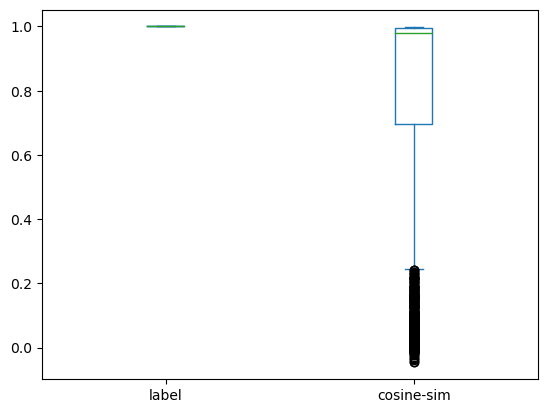

In [13]:
X_test_score[X_test_score["label"] == 1].plot.box()

<AxesSubplot:>

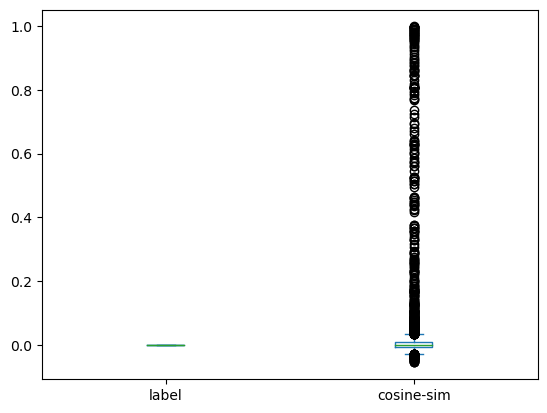

In [14]:
X_test_score[X_test_score["label"] == 0].plot.box()